# Tutorial 9

# Part A: Pretrained Model

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [ ]:
def set_random_seed(seed):
    seed_id = seed
    torch.manual_seed(seed_id)
    np.random.seed(seed_id)

set_random_seed(1)

def count_acc(logits, label):
    """
    :param logits: n * c; n=num of samples, c=number of classes
    :param label: n
    :return: accuracy
    """
    pred = torch.argmax(logits, dim=1)
    return (pred == label).float().mean().item()

In [ ]:
import urllib
def download_file_from_url(url, filename):
    try: 
        urllib.URLopener().retrieve(url, filename)
    except: 
        urllib.request.urlretrieve(url, filename)

In [ ]:
download_file_from_url("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", "imagenet_classes.txt")

In [ ]:
def get_topk_classes(probabilities, topk=5):
    categories = None
    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]
    topk_prob, topk_catid = torch.topk(probabilities, topk)
    for i in range(topk_prob.size(0)):
        print(categories[topk_catid[i]], topk_prob[i].item())

In [ ]:
# https://img2.baidu.com/it/u=1457249248,1484069236&fm=26&fmt=auto
# https://github.com/pytorch/hub/raw/master/images/dog.jpg
url_dog = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
dog_filename = "dog.jpg"
download_file_from_url(url_dog, dog_filename)

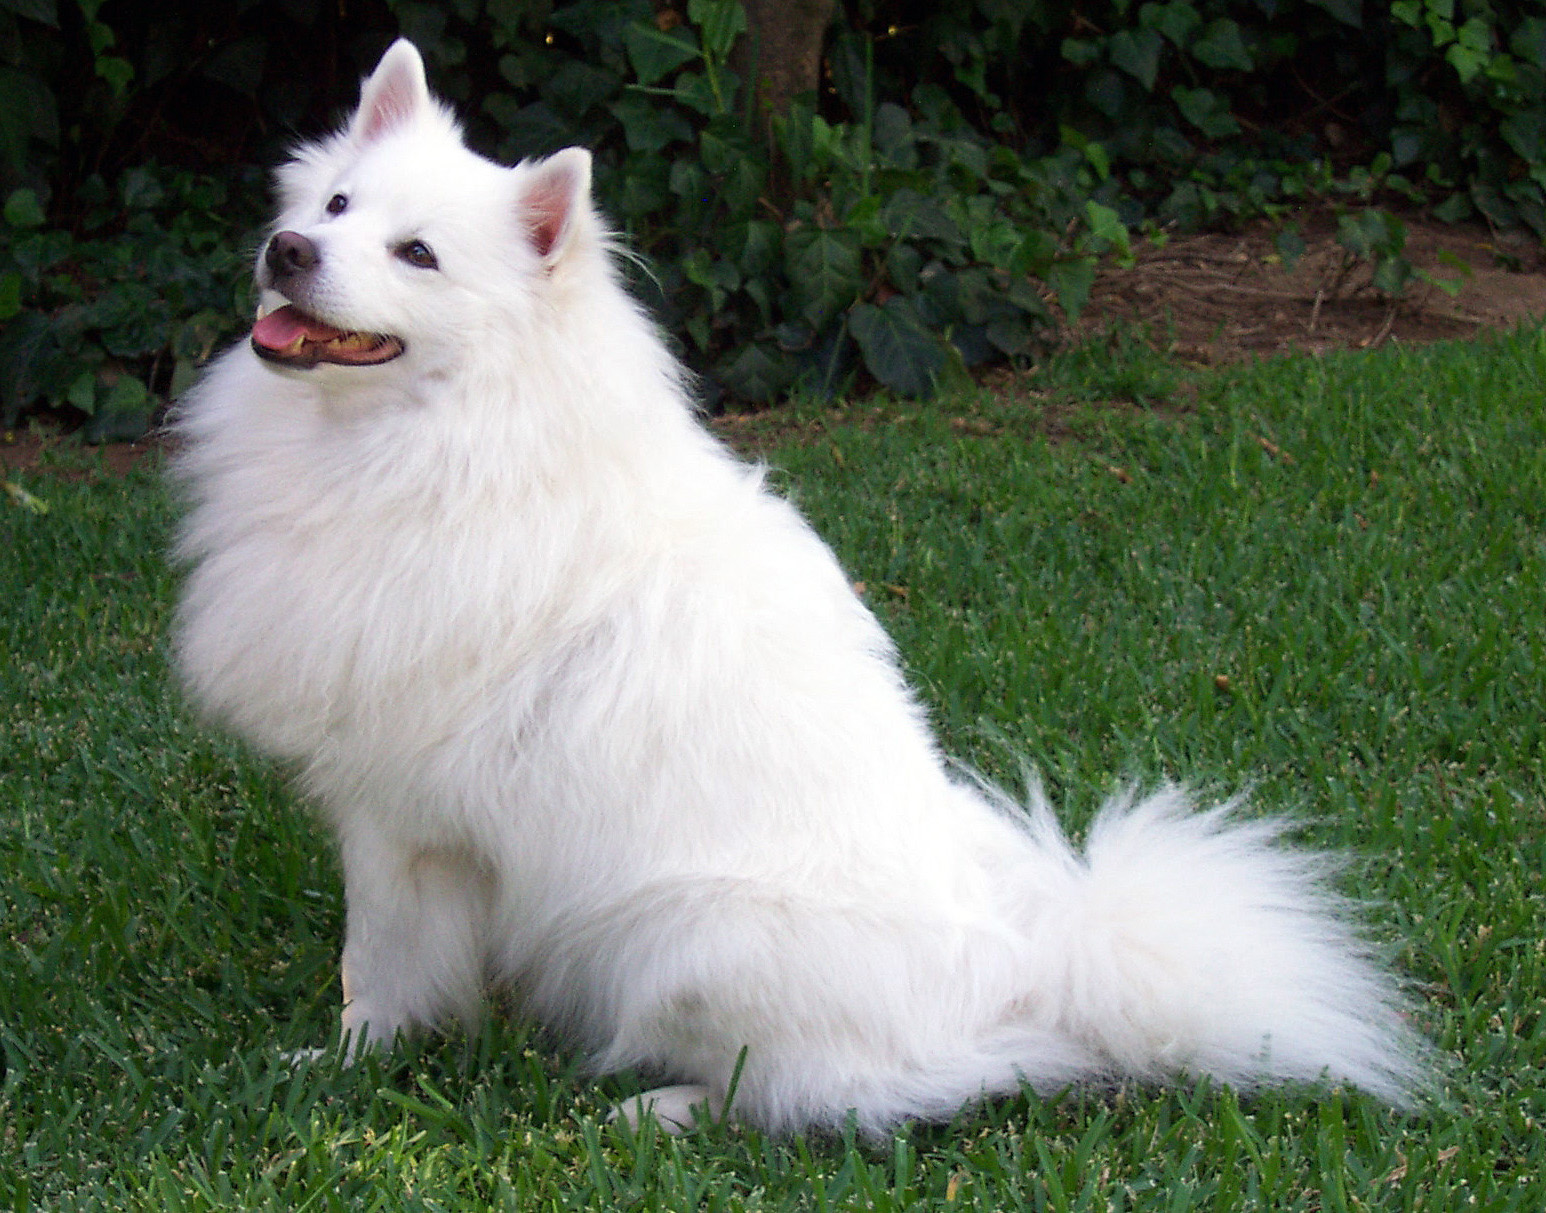

In [ ]:
def show_an_image(filename):
    from IPython.display import display, Image
    display(Image(filename, width = 400))

show_an_image(dog_filename)

In [ ]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
from torchvision.io import read_image

from torchvision.models import resnet18
resnet18 = resnet18(pretrained=True, progress=False).eval()
def pred_by_resnet18(filename, topk=5):
    # read image from file
    input_image = Image.open(filename).convert('RGB')
    # transform the image to tensor the the model
    m_transforms = transforms.Compose([
                transforms.Resize([256, ]),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    x = m_transforms(input_image)
    # make prediction
    y_pred = resnet18.forward(x.unsqueeze(0))
    # get the topk predicted classes
    y_pred = y_pred.softmax(axis=1)
    get_topk_classes(y_pred.squeeze(0), topk=topk)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [ ]:
pred_by_resnet18(dog_filename, topk=10)

Samoyed 0.8846225142478943
Arctic fox 0.045805174857378006
white wolf 0.0442761555314064
Pomeranian 0.005621383432298899
Great Pyrenees 0.004652013536542654
Eskimo dog 0.0037816704716533422
keeshond 0.0034971965942531824
West Highland white terrier 0.002370412228628993
Siberian husky 0.0015191296115517616
kuvasz 0.0005503308493643999


# Part B: Clustering

In [ ]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

from sklearn.cluster import KMeans

np.random.seed(0)


n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
noisy_circles_l = datasets.make_moons(n_samples=n_samples, noise=0.09) 
noise = np.ones([100,2])*10+ np.random.uniform(low=10,high=50, size = [100,2])
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8,centers = 4)


blobs_X, blobs_y = datasets.make_blobs(n_samples=n_samples, random_state=8,centers = 4)
blobs_X = np.concatenate((blobs_X, noise), axis=0)
blobs_noise = [blobs_X,blobs_y]

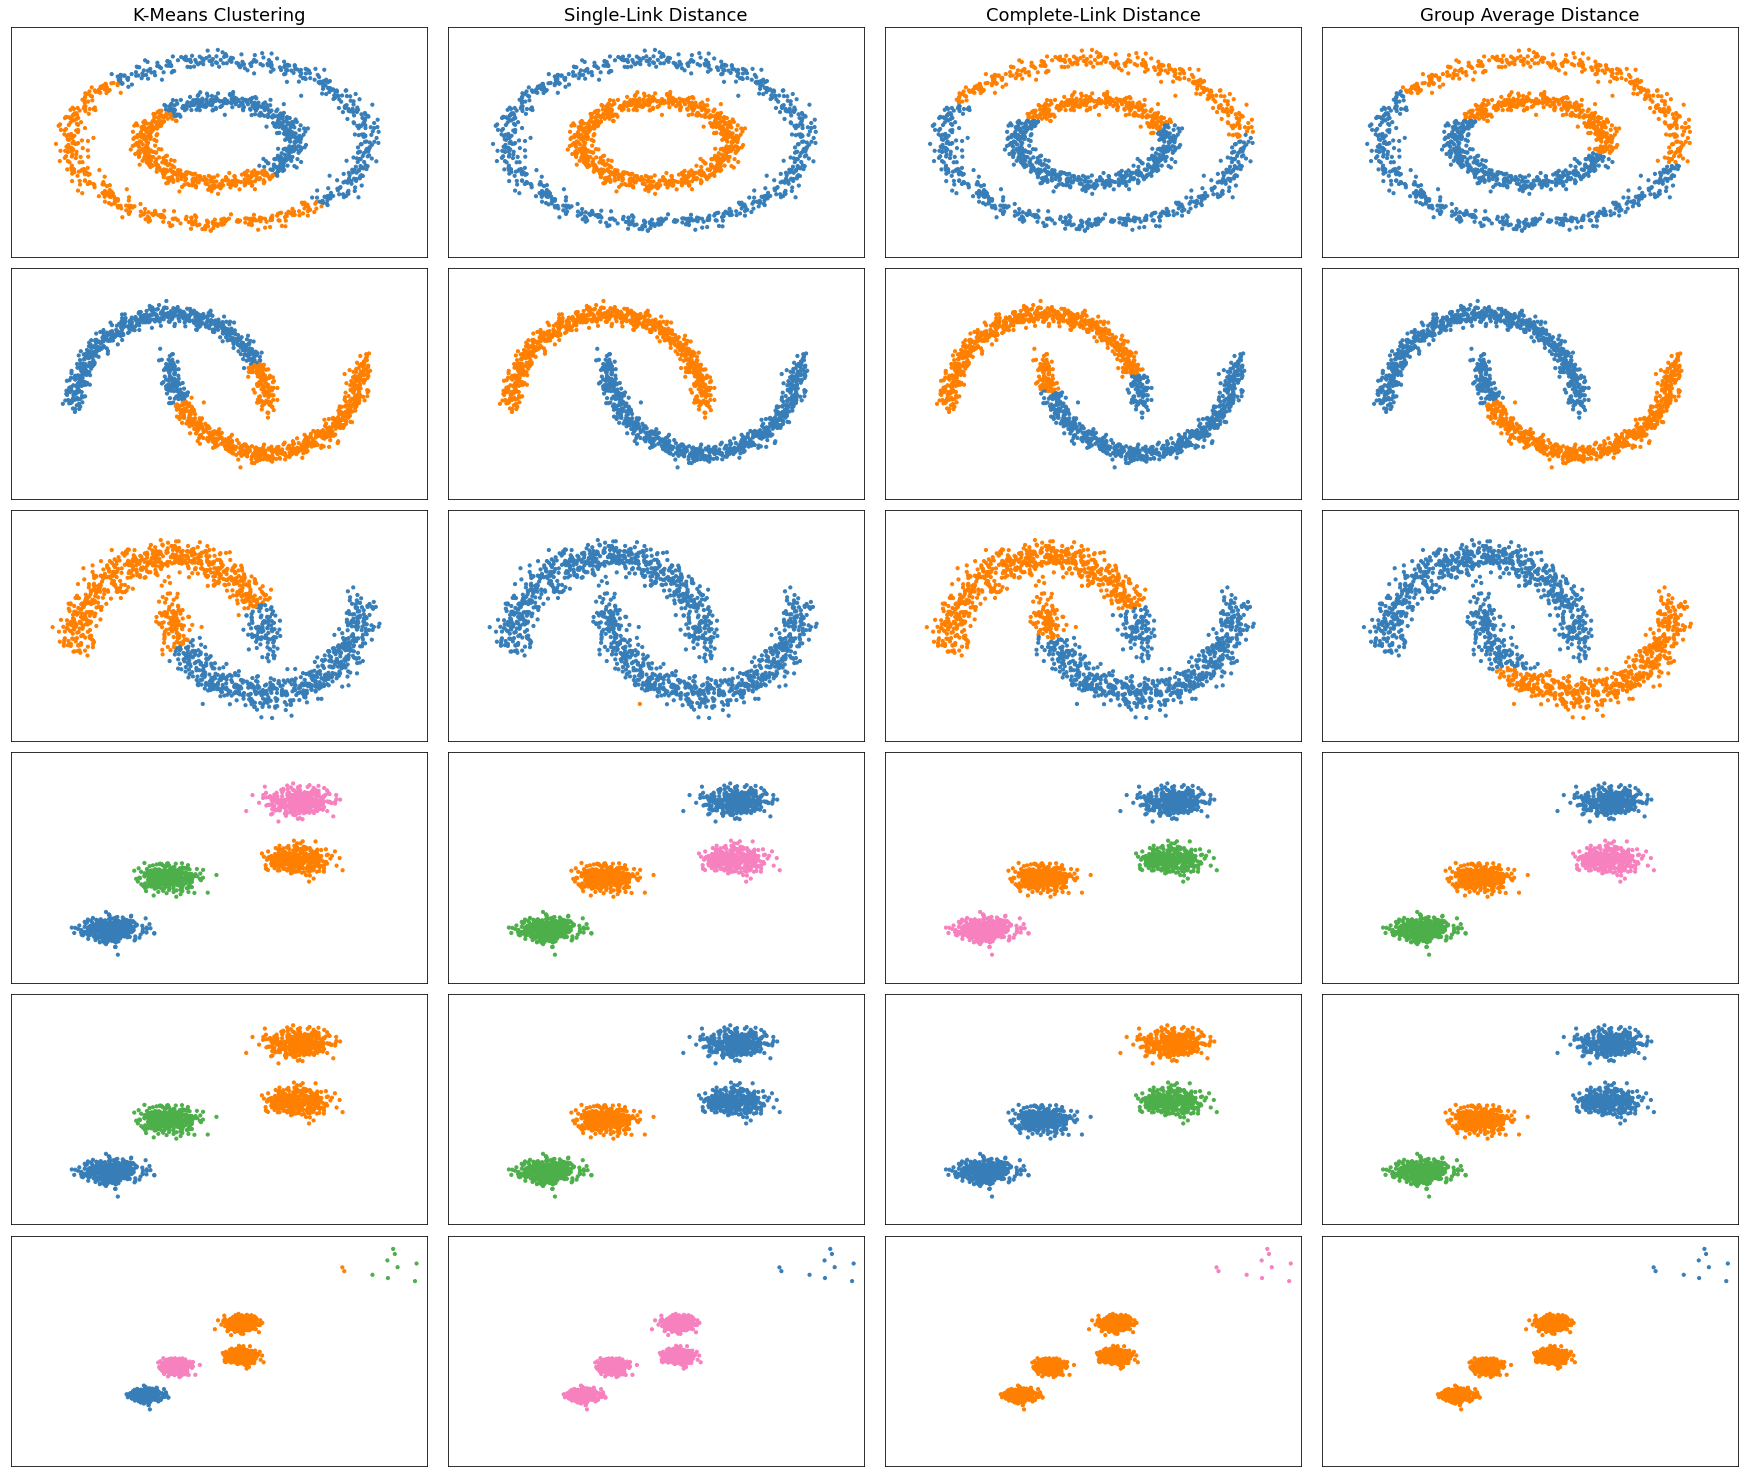

In [ ]:
plot_num = 1


plt.subplots_adjust(
    left=0.001, right=4, bottom=0.001, top=5, wspace=0.05, hspace=0.05
)

datasets = [
    (noisy_circles, {"n_clusters": 2}),
    (noisy_moons, {"n_clusters": 2}),
    (noisy_circles_l, {"n_clusters": 2}),
    (blobs, {"n_clusters": 4}),
    (blobs, {"n_clusters": 3}),
    (blobs_noise, {"n_clusters": 4})
]



for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    complete = cluster.AgglomerativeClustering(
        n_clusters=algo_params["n_clusters"], linkage="complete"
    )
    average = cluster.AgglomerativeClustering(
        n_clusters=algo_params["n_clusters"], linkage="average"
    )
    single = cluster.AgglomerativeClustering(
        n_clusters=algo_params["n_clusters"], linkage="single"
    )
    k_means = KMeans(n_clusters=algo_params["n_clusters"], random_state=0)


    clustering_algorithms = (
        ("K-Means Clustering", k_means), 
        ("Single-Link Distance", single),
        ("Complete-Link Distance", complete),
        ("Group Average Distance", average), 
    )


    for name, algorithm in clustering_algorithms:
        algorithm.fit(X)
        if name== "K-Means Clustering":
            y_pred = algorithm.predict(X)
        else:
            y_pred = algorithm.labels_.astype(int)
            

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1

plt.show()



    


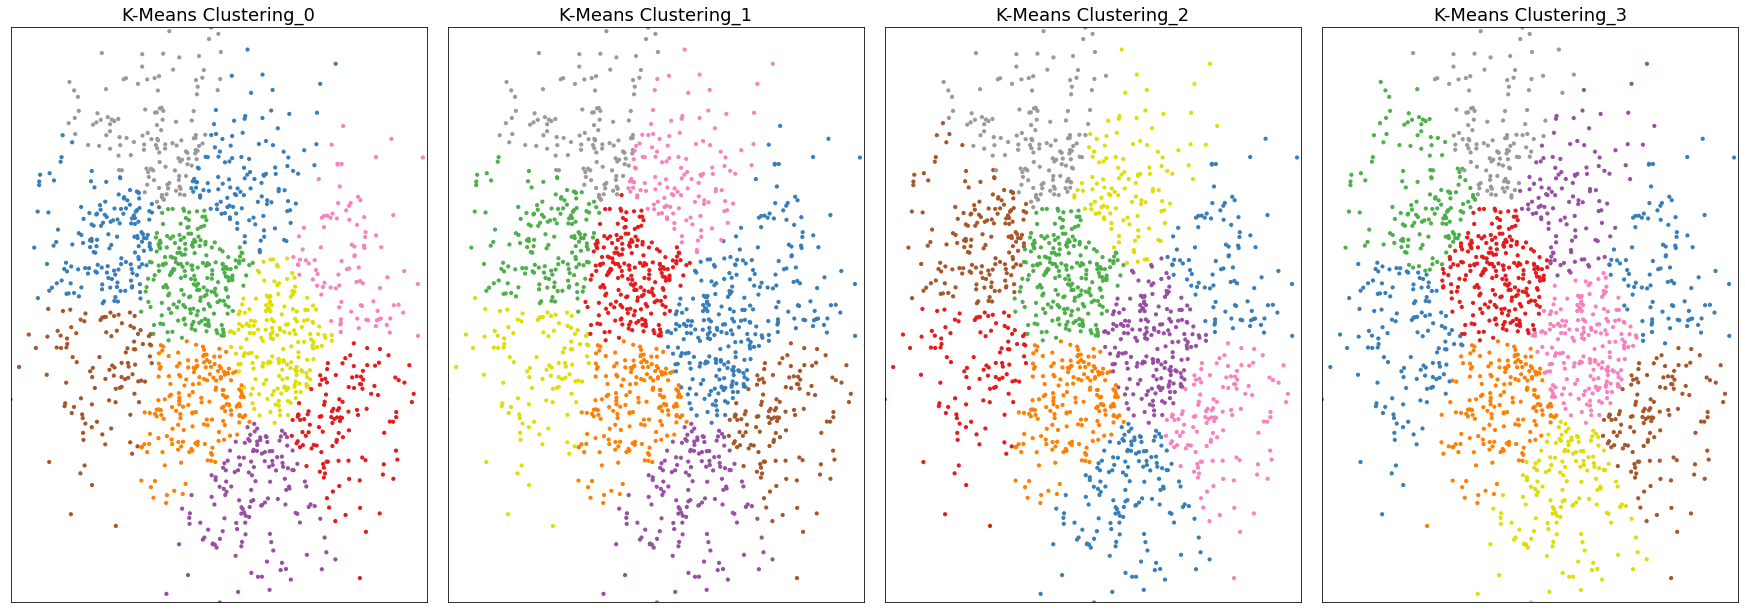

In [ ]:
plot_num = 1
noisy_moons_ = datasets.make_moons(n_samples=n_samples, noise=0.5)


plt.subplots_adjust(
    left=0.001, right=6, bottom=0.001, top=2, wspace=0.05, hspace=0.05
)

datasets = [
    (noisy_moons_, {"n_clusters": 10}),
    (noisy_moons_, {"n_clusters": 10}),
]



for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values

    X, y = dataset
    print()

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============

    k_means0 = KMeans(n_clusters=algo_params["n_clusters"], random_state=0)
    k_means1 = KMeans(n_clusters=algo_params["n_clusters"], random_state=1)
    k_means2 = KMeans(n_clusters=algo_params["n_clusters"], random_state=2)
    k_means3 = KMeans(n_clusters=algo_params["n_clusters"], random_state=6)    

    clustering_algorithms = (
        ("K-Means Clustering_0", k_means0), 
        ("K-Means Clustering_1", k_means1), 
         ("K-Means Clustering_2", k_means2), 
         ("K-Means Clustering_3", k_means3), 
    )


    for name, algorithm in clustering_algorithms:
        algorithm.fit(X)
        if name== "K-Means Clustering":
            y_pred = algorithm.predict(X)
        else:
            y_pred = algorithm.labels_.astype(int)
            

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1

plt.show()



    
